In [47]:
from collections import Counter
import matplotlib.pyplot as plt
import networkx as nx
import sys
import random
import time
from TwitterAPI import TwitterAPI

In [48]:
consumer_key = ''
consumer_secret = ''
access_token = ''
access_token_secret = ''

In [49]:
def get_twitter():
    """ Construct an instance of TwitterAPI using the tokens you entered above.
    Returns:
      An instance of TwitterAPI.
    """
    return TwitterAPI(consumer_key, consumer_secret, access_token, access_token_secret)

In [50]:
def read_screen_names(filename):
    """
    Read a text file containing Twitter screen_names, one per line.

    Params:
        filename....Name of the file to read.
    Returns:
        A list of strings, one per screen_name, in the order they are listed
        in the file.

    Here's a doctest to confirm your implementation is correct.
    >>> read_screen_names('candidates.txt')
    ['DrJillStein', 'GovGaryJohnson', 'HillaryClinton', 'realDonaldTrump']
    """
    names=[]
    file = open(filename)
    names=file.read().split()
    file.close()
    random.shuffle(names)
    return names[:5]

In [51]:
def robust_request(twitter, resource, params, max_tries=5):
    """ If a Twitter request fails, sleep for 15 minutes.
    Do this at most max_tries times before quitting.
    Args:
      twitter .... A TwitterAPI object.
      resource ... A resource string to request; e.g., "friends/ids"
      params ..... A parameter dict for the request, e.g., to specify
                   parameters like screen_name or count.
      max_tries .. The maximum number of tries to attempt.
    Returns:
      A TwitterResponse object, or None if failed.
    """
    for i in range(max_tries):
        request = twitter.request(resource, params)
        if request.status_code == 200:
            return request
        else:
            print('Got error %s \nsleeping for 15 minutes.' % request.text)
            sys.stderr.flush()
            time.sleep(61 * 15)

In [52]:
def get_users(twitter, screen_names):
    """Retrieve the Twitter user objects for each screen_name.
    Params:
        twitter........The TwitterAPI object.
        screen_names...A list of strings, one per screen_name
    Returns:
        A list of dicts, one per user, containing all the user information
        (e.g., screen_name, id, location, etc)

    See the API documentation here: https://dev.twitter.com/rest/reference/get/users/lookup

    In this example, I test retrieving two users: twitterapi and twitter.

    >>> twitter = get_twitter()
    >>> users = get_users(twitter, ['twitterapi', 'twitter'])
    >>> [u['id'] for u in users]
    [6253282, 783214]
    """

    request = robust_request(twitter,'users/lookup',{'screen_name':screen_names},max_tries=5)
    response = [i for i in request]
    return response

In [53]:
def get_friends(twitter, screen_name):
    """ Return a list of Twitter IDs for users that this person follows, up to 5000.
    See https://dev.twitter.com/rest/reference/get/friends/ids

    Note, because of rate limits, it's best to test this method for one candidate before trying
    on all candidates.

    Args:
        twitter.......The TwitterAPI object
        screen_name... a string of a Twitter screen name
    Returns:
        A list of ints, one per friend ID, sorted in ascending order.

    Note: If a user follows more than 5000 accounts, we will limit ourselves to
    the first 5000 accounts returned.

    In this test case, I return the first 5 accounts that I follow.
    >>> twitter = get_twitter()
    >>> get_friends(twitter, 'aronwc')[:5]
    [695023, 1697081, 8381682, 10204352, 11669522]
    """
    user_ids=[]
    request = robust_request(twitter,'friends/ids',{'screen_name':screen_name,'count':5000},max_tries=5)
    user_ids = [i for i in request]
    user_ids.sort(key=int)
    return user_ids

In [54]:
def add_all_friends(twitter, users):
    """ Get the list of accounts each user follows.
    I.e., call the get_friends method for all 4 candidates.

    Store the result in each user's dict using a new key called 'friends'.

    Args:
        twitter...The TwitterAPI object.
        users.....The list of user dicts.
    Returns:
        Nothing

    >>> twitter = get_twitter()
    >>> users = [{'screen_name': 'aronwc'}]
    >>> add_all_friends(twitter, users)
    >>> users[0]['friends'][:5]
    [695023, 1697081, 8381682, 10204352, 11669522]
    """
    for i in users:
        i.update(dict(friends=get_friends(twitter,i['screen_name'])))
    return

In [55]:
def print_num_friends(users):
    """Print the number of friends per candidate, sorted by candidate name.
    See Log.txt for an example.
    Args:
        users....The list of user dicts.
    Returns:
        Nothing
    """
    users=sorted(users,key=lambda x:x['screen_name']) #sorting by name.
    for i in users:
        print(i['screen_name'],len(i['friends']))
    return

In [56]:
def count_friends(users):
    """ Count how often each friend is followed.
    Args:
        users: a list of user dicts
    Returns:
        a Counter object mapping each friend to the number of candidates who follow them.
        Counter documentation: https://docs.python.org/dev/library/collections.html#collections.Counter

    In this example, friend '2' is followed by three different users.
    >>> c = count_friends([{'friends': [1,2]}, {'friends': [2,3]}, {'friends': [2,3]}])
    >>> c.most_common()
    [(2, 3), (3, 2), (1, 1)]
    """
    counter = Counter()
    for i in users:
        counter.update(i['friends'])
    counter.most_common()
    return counter

In [57]:
def friend_overlap(users):
    """
    Compute the number of shared accounts followed by each pair of users.

    Args:
        users...The list of user dicts.

    Return: A list of tuples containing (user1, user2, N), where N is the
        number of accounts that both user1 and user2 follow.  This list should
        be sorted in descending order of N. Ties are broken first by user1's
        screen_name, then by user2's screen_name (sorted in ascending
        alphabetical order). See Python's builtin sorted method.

    In this example, users 'a' and 'c' follow the same 3 accounts:
    >>> friend_overlap([
    ...     {'screen_name': 'a', 'friends': ['1', '2', '3']},
    ...     {'screen_name': 'b', 'friends': ['2', '3', '4']},
    ...     {'screen_name': 'c', 'friends': ['1', '2', '3']},
    ...     ])
    [('a', 'c', 3), ('a', 'b', 2), ('b', 'c', 2)]
    """
    overlap_users = []
    for i in range(len(users)):
        for j in range(i+1,len(users)):
            x = set(users[i]['friends']) & set(users[j]['friends'])
            y = (users[i]['screen_name'],users[j]['screen_name'],len(x))
            overlap_users.append(y)
    overlap_users=sorted(overlap_users,key=lambda x: -x[2])
    return overlap_users

In [58]:
def followed_by_hillary_and_donald(users, twitter):
    """
    Find and return the screen_names of the Twitter users followed by both Hillary
    Clinton and Donald Trump. You will need to use the TwitterAPI to convert
    the Twitter ID to a screen_name. See:
    https://dev.twitter.com/rest/reference/get/users/lookup

    Params:
        users.....The list of user dicts
        twitter...The Twitter API object
    Returns:
        A list of strings containing the Twitter screen_names of the users
        that are followed by both Hillary Clinton and Donald Trump.
    """
    common_ids=set()
    for i in users:
        if(i['screen_name']=='RussoBrothers'):
            for j in users:
                if(j['screen_name']=='MarvelStudios'):
                    common_ids= set(i['friends'])&set(j['friends'])
    response = robust_request(twitter,'users/lookup',{'user_id':common_ids})
    user = [r for r in response]
    return user[0]['screen_name']
   

In [59]:
def create_graph(users, friend_counts):
    """ Create a networkx undirected Graph, adding each candidate and friend
        as a node.  Note: while all candidates should be added to the graph,
        only add friends to the graph if they are followed by more than one
        candidate. (This is to reduce clutter.)

        Each candidate in the Graph will be represented by their screen_name,
        while each friend will be represented by their user id.

    Args:
      users...........The list of user dicts.
      friend_counts...The Counter dict mapping each friend to the number of candidates that follow them.
    Returns:
      A networkx Graph
    """
    G = nx.Graph()
    for i in users:
        G.add_node(i['screen_name'])
        for j in i['friends']:
            if (friend_counts[j]>1):
                G.add_node(j)
                G.add_edge(i['screen_name'],j)
    return G
                

In [60]:
def draw_network(graph, users, filename):
    """
    Draw the network to a file. Only label the candidate nodes; the friend
    nodes should have no labels (to reduce clutter).

    Methods you'll need include networkx.draw_networkx, plt.figure, and plt.savefig.

    Your figure does not have to look exactly the same as mine, but try to
    make it look presentable.
    """
    layout = nx.spring_layout(graph)
    labels = {}
    lists = []
    for i in users:
        lists.append(i['screen_name'])
    for n in graph.nodes():
        if n in lists:
            labels[n]=n
    plt.figure(figsize=(20,20),dpi=50)
    plt.savefig(filename,type="PNG")
    nx.draw_networkx(graph,pos=layout,labels=labels,node_size=80,alpha=0.5,width=0.1,font_size=20)
#     nx.draw_networkx_labels(graph,layout,labels=labels)
    plt.axis("off")
    plt.show()

Established Twitter connection.
Read screen names: ['MarvelStudios', 'SamuelLJackson', '_realjoshbrolin', 'gwynethpaltrow', 'idriselba']
found 5 users with screen_names ['GwynethPaltrow', 'MarvelStudios', 'SamuelLJackson', '_realjoshbrolin', 'idriselba']
Friends per candidate:
GwynethPaltrow 192
MarvelStudios 81
SamuelLJackson 871
_realjoshbrolin 196
idriselba 947
graph has 181 nodes and 386 edges


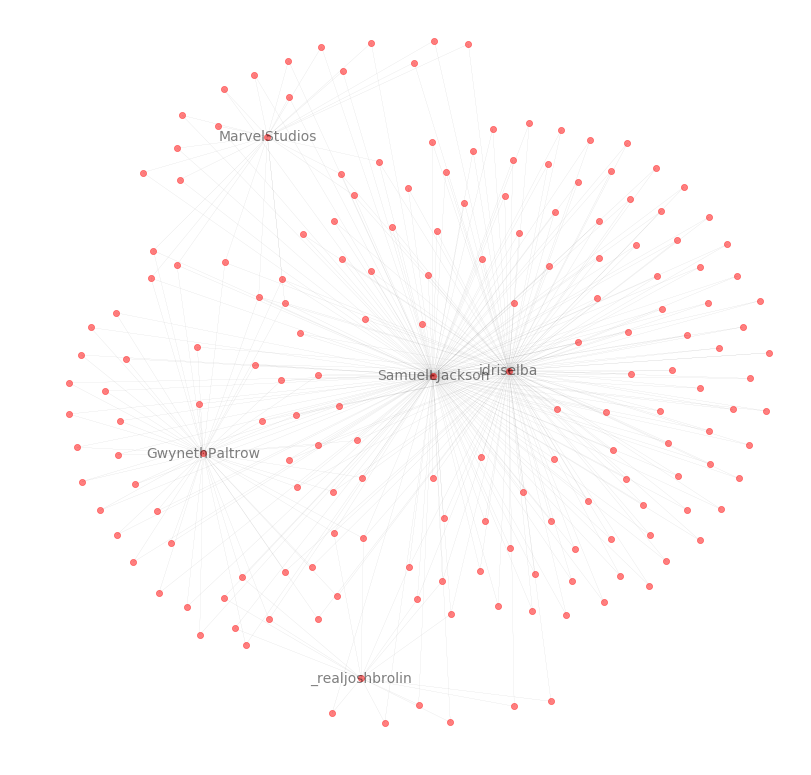

network drawn to network.png


In [61]:
def main():
    """ Main method. You should not modify this. """
    twitter = get_twitter()
    screen_names = read_screen_names('cast_list.txt')
    print('Established Twitter connection.')
    print('Read screen names: %s' % screen_names)
    users = sorted(get_users(twitter, screen_names), key=lambda x: x['screen_name'])
    print('found %d users with screen_names %s' %
          (len(users), str([u['screen_name'] for u in users])))
    add_all_friends(twitter, users)
    print('Friends per candidate:')
    print_num_friends(users)
    friend_counts = count_friends(users)
#     print('Most common friends:\n%s' % str(friend_counts.most_common(5)))
#     print('Friend Overlap:\n%s' % str(friend_overlap(users)))
#     print('User followed by Hillary and Donald: %s' % str(followed_by_hillary_and_donald(users, twitter)))

    graph = create_graph(users, friend_counts)
    print('graph has %s nodes and %s edges' % (len(graph.nodes()), len(graph.edges())))
    draw_network(graph, users, 'network.png')
    print('network drawn to network.png')


if __name__ == '__main__':
    main()

# That's it for now! This should give you an introduction to some of the data we'll study in this course.
